# ANÁLISIS EXPLORATORIO DE DATOS

### Importación de librerías

In [1]:
from urllib.parse import urlencode
import datetime as dt
from pathlib import Path
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

## 1) CONFIG (ApiResfull para consumo de datos)

In [11]:
API_ROOT = "http://127.0.0.1:8000"
API_PREFIX = "/api"
BASE_INGESTAS = f"{API_ROOT}{API_PREFIX}/ingestas"

DATASOURCE = "B"  # A=export/csv, B=by-asset-motor, C=list_ingestas
ASSET_CODIGO = "37156"
MOTOR_CODIGO = "Motor_001"
TS_LOCAL_FROM = dt.datetime(2025, 8, 11, 2, 40, 0)
TS_LOCAL_TO   = dt.datetime(2025, 8, 21, 8, 45, 0)
VARIABLE = None

EXPECTED_SEC = 900
PAGE_SIZE = 200

AUTH_MODE = "x-api-key"
BEARER_TOKEN = ""
BASIC_USER = ""
BASIC_PASS = ""
X_API_KEY = "zxcvbnm"

OUTDIR = Path("eda_outputs")
OUTDIR.mkdir(exist_ok=True, parents=True)
print("Config OK —", BASE_INGESTAS)


Config OK — http://127.0.0.1:8000/api/ingestas


## 2) Sesión HTTP y test

In [12]:

session = requests.Session()
headers = {}
auth = None

if AUTH_MODE == "bearer" and BEARER_TOKEN:
    headers["Authorization"] = f"Bearer {BEARER_TOKEN}"
elif AUTH_MODE == "basic" and BASIC_USER:
    auth = (BASIC_USER, BASIC_PASS)
elif AUTH_MODE == "x-api-key" and X_API_KEY:
    headers["x-api-key"] = X_API_KEY

print("Headers:", headers)
test_url = f"{BASE_INGESTAS}/latest"
r = session.get(test_url, headers=headers, auth=auth, timeout=30)
print("Test GET", test_url, "=>", r.status_code)
if r.status_code != 200:
    print("Respuesta:", r.text)
r.raise_for_status()
print("✓ Conectividad OK")


Headers: {'x-api-key': 'zxcvbnm'}
Test GET http://127.0.0.1:8000/api/ingestas/latest => 200
✓ Conectividad OK


## 3) Imports y helpers

In [13]:
def load_via_export_csv(base_url, asset=None, motor=None, variable=None, t_from=None, t_to=None):
    from io import StringIO
    params = {}
    if asset: params["asset_codigo"] = asset
    if motor: params["motor_codigo"] = motor
    if variable: params["variable"] = variable
    if t_from: params["ts_local_from"] = t_from.isoformat()
    if t_to: params["ts_local_to"] = t_to.isoformat()
    url = f"{base_url}/export/csv?{urlencode(params)}"
    print("GET", url)
    r = session.get(url, headers=headers, auth=auth, timeout=60)
    if r.status_code != 200:
        print("Error:", r.status_code, r.text); r.raise_for_status()
    return pd.read_csv(StringIO(r.text), parse_dates=["ts_utc","ts_local_tz"])

def load_via_by_asset_motor(base_by_asset, asset, motor, t_from, t_to):
    url = base_by_asset
    params = {"asset_codigo": asset, "motor_codigo": motor,
              "ts_from": t_from.isoformat(), "ts_to": t_to.isoformat()}
    print("GET", url, params)
    r = session.get(url, params=params, headers=headers, auth=auth, timeout=60)
    if r.status_code != 200:
        print("Error:", r.status_code, r.text); r.raise_for_status()
    payload = r.json()
    df = pd.DataFrame(payload.get("items", []))
    if "ts_utc" in df.columns:
        df["ts_utc"] = pd.to_datetime(df["ts_utc"])
    if "ts_local_tz" in df.columns:
        df["ts_local_tz"] = pd.to_datetime(df["ts_local_tz"])
    return df

def load_via_list_ingestas(base_list, asset=None, motor=None, variable=None, t_from=None, t_to=None, page_size=100):
    rows, offset = [], 0
    while True:
        params = {"limit": page_size, "offset": offset, "sort": "ts_local_tz"}
        if asset: params["asset_codigo"] = asset
        if motor: params["motor_codigo"] = motor
        if variable: params["variable"] = variable
        if t_from: params["ts_local_from"] = t_from.isoformat()
        if t_to: params["ts_local_to"] = t_to.isoformat()
        print("GET", base_list, params)
        r = session.get(base_list, params=params, headers=headers, auth=auth, timeout=60)
        if r.status_code != 200:
            print("Error:", r.status_code, r.text); r.raise_for_status()
        batch = r.json()
        if not batch:
            break
        rows.extend(batch)
        if len(batch) < page_size:
            break
        offset += page_size
    df = pd.DataFrame(rows)
    if "ts_utc" in df.columns:
        df["ts_utc"] = pd.to_datetime(df["ts_utc"])
    if "ts_local_tz" in df.columns:
        df["ts_local_tz"] = pd.to_datetime(df["ts_local_tz"])
    return df


## 4) Carga de datos

In [14]:

if DATASOURCE == "A":
    df = load_via_export_csv(BASE_INGESTAS, ASSET_CODIGO, MOTOR_CODIGO, VARIABLE, TS_LOCAL_FROM, TS_LOCAL_TO)
elif DATASOURCE == "B":
    df = load_via_by_asset_motor(BASE_INGESTAS + "/by-asset-motor", ASSET_CODIGO, MOTOR_CODIGO, TS_LOCAL_FROM, TS_LOCAL_TO)
elif DATASOURCE == "C":
    df = load_via_list_ingestas(BASE_INGESTAS, ASSET_CODIGO, MOTOR_CODIGO, VARIABLE, TS_LOCAL_FROM, TS_LOCAL_TO, page_size=PAGE_SIZE)
else:
    raise ValueError("DATASOURCE debe ser 'A', 'B' o 'C'")
print("Filas recibidas:", len(df))
df.head(5)


GET http://127.0.0.1:8000/api/ingestas/by-asset-motor {'asset_codigo': '37156', 'motor_codigo': 'Motor_001', 'ts_from': '2025-08-11T02:40:00', 'ts_to': '2025-08-21T08:45:00'}
Filas recibidas: 21697


,asset_codigo,motor_codigo,ts_utc,ts_local_tz,variable,valor,archivo_origen,ingesta_id,recibido_en
0,37156,Motor_001,2025-08-21 03:45:00-05:00,2025-08-21 03:45:00,Vibration (Tangential),2.15,vibration_tangential.csv,21697,2025-11-15T16:40:28.400056-05:00
1,37156,Motor_001,2025-08-21 03:45:00-05:00,2025-08-21 03:45:00,Vibration (Radial),2.752,vibration_radial.csv,20712,2025-11-15T16:40:28.255091-05:00
2,37156,Motor_001,2025-08-21 03:45:00-05:00,2025-08-21 03:45:00,Vibration (Axial),1.332,vibration_axial.csv,19727,2025-11-15T16:40:28.056118-05:00
3,37156,Motor_001,2025-08-21 03:45:00-05:00,2025-08-21 03:45:00,Unbalance (BETA),1.0,unbalance_beta.csv,18742,2025-11-15T16:40:27.883394-05:00
4,37156,Motor_001,2025-08-21 03:45:00-05:00,2025-08-21 03:45:00,Total Number Of Starts,97.0,total_starts.csv,17757,2025-11-15T16:40:27.644607-05:00


## 5) Pivot a formato ancho

In [15]:
required_cols = {"ts_utc","variable","valor"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Faltan columnas mínimas en la respuesta de la API: {missing}")
df_wide = df.pivot(index="ts_utc", columns="variable", values="valor").sort_index()
df_wide.index.name = "ts_utc"
print("Formato Ancho:", df_wide.shape)
df_wide.head(5)


Formato Ancho: (995, 22)


variable,Acceleration RMS (Axial),Acceleration RMS (Radial),Acceleration RMS (Tangential),Bearing Condition,Looseness (BETA),Misalignment (BETA),Motor Supply Frequency,Nr. Of Starts Between Measurements,Output Power,Overall Vibration,Peak to Peak,Peak to Peak (Axial),Peak to Peak (Radial),Peak to Peak (Tangential),Skin Temperature,Speed,Total Number Of Starts,Total Running Time,Unbalance (BETA),Vibration (Axial),Vibration (Radial),Vibration (Tangential)
ts_utc,,,,,,,,,,,,,,,,,,,,,,
2025-08-11 02:40:01-05:00,0.7041,0.1873,0.5645,1.0,0.0,0.0,36.16,0.0,100.56,2.984,1.2021,4.2461,1.2021,3.082,44.6,1078.3,87.0,5.6,1.0,1.04,2.984,2.346
2025-08-11 02:55:00-05:00,0.6943,0.1898,0.5566,1.0,0.0,0.0,36.16,0.0,105.04,2.973,1.083,4.125,1.083,3.0918,44.0,1078.0,87.0,5.9,1.0,1.062,2.973,2.307
2025-08-11 03:10:01-05:00,0.6714,0.1941,0.561,1.0,0.0,0.0,36.12,0.0,87.49,2.992,1.2012,4.0938,1.2012,2.9609,43.1,1078.2,87.0,6.1,1.0,1.036,2.992,2.293
2025-08-11 03:25:00-05:00,0.6812,0.1938,0.5596,1.0,0.0,0.0,36.16,0.0,97.98,3.021,1.2432,4.2617,1.2432,3.0137,44.2,1078.4,87.0,6.4,1.0,1.046,3.021,2.344
2025-08-11 03:40:01-05:00,0.7212,0.183,0.5464,1.0,0.0,0.0,36.16,0.0,95.58,3.004,1.0576,4.2656,1.0576,2.9375,44.7,1078.6,87.0,6.6,1.0,0.991,3.004,2.33


## 6) Δt, gaps, cobertura diaria

In [16]:

delta = df_wide.index.to_series().diff().dt.total_seconds()
gap_threshold = EXPECTED_SEC * 1.5
gaps = delta[delta > gap_threshold]
print("Resumen Δt (s):"); print(delta.describe())
print("\nGaps detectados (> %.1f s) => %d" % (gap_threshold, gaps.notna().sum()))
gaps.head(10)


Resumen Δt (s):
count    994.000000
mean     873.137827
std      122.291803
min        1.000000
25%      899.000000
50%      899.000000
75%      901.000000
max      901.000000
Name: ts_utc, dtype: float64

Gaps detectados (> 1350.0 s) => 0


Series([], Name: ts_utc, dtype: float64)

In [24]:
short_intervals = delta[delta < 900]  # menos de 10 minutos
print("Intervalos cortos detectados:", len(short_intervals))
display(short_intervals.head(10))


Intervalos cortos detectados: 526


ts_utc
2025-08-11 02:55:00-05:00    899.0
2025-08-11 03:25:00-05:00    899.0
2025-08-11 03:55:00-05:00    899.0
2025-08-11 04:25:00-05:00    899.0
2025-08-11 04:55:00-05:00    899.0
2025-08-11 05:25:00-05:00    899.0
2025-08-11 05:55:00-05:00    899.0
2025-08-11 06:25:00-05:00    899.0
2025-08-11 06:55:00-05:00    899.0
2025-08-11 07:25:00-05:00    899.0
Name: ts_utc, dtype: float64

In [18]:
# Toma los timestamps que tuvieron intervalo corto
idx_short = short_intervals.index
df.loc[df['ts_utc'].isin(idx_short) | df['ts_utc'].shift(-1).isin(idx_short)].sort_values('ts_utc').head(10)


,asset_codigo,motor_codigo,ts_utc,ts_local_tz,variable,valor,archivo_origen,ingesta_id,recibido_en
20244,37156,Motor_001,2025-08-11 19:00:00-05:00,2025-08-11 19:00:00,Nr. Of Starts Between Measurements,0.0,starts_between_meas.csv,14839,2025-11-15T16:40:27.309846-05:00
20243,37156,Motor_001,2025-08-11 19:00:00-05:00,2025-08-11 19:00:00,Total Running Time,22.0,total_run_time.csv,15834,2025-11-15T16:40:27.480207-05:00
20242,37156,Motor_001,2025-08-11 19:00:00-05:00,2025-08-11 19:00:00,Total Number Of Starts,87.0,total_starts.csv,16829,2025-11-15T16:40:27.644607-05:00
20241,37156,Motor_001,2025-08-11 19:10:01-05:00,2025-08-11 19:10:01,Acceleration RMS (Axial),0.8301,acc_rms_axial.csv,67,2025-11-15T16:40:24.578758-05:00
18129,37156,Motor_001,2025-08-12 19:00:00-05:00,2025-08-12 19:00:00,Nr. Of Starts Between Measurements,0.0,starts_between_meas.csv,14936,2025-11-15T16:40:27.309846-05:00
18128,37156,Motor_001,2025-08-12 19:00:00-05:00,2025-08-12 19:00:00,Total Running Time,46.0,total_run_time.csv,15931,2025-11-15T16:40:27.480207-05:00
18127,37156,Motor_001,2025-08-12 19:00:00-05:00,2025-08-12 19:00:00,Total Number Of Starts,87.0,total_starts.csv,16926,2025-11-15T16:40:27.644607-05:00
18126,37156,Motor_001,2025-08-12 19:10:01-05:00,2025-08-12 19:10:01,Acceleration RMS (Axial),0.8594,acc_rms_axial.csv,163,2025-11-15T16:40:24.578758-05:00
16017,37156,Motor_001,2025-08-13 19:00:00-05:00,2025-08-13 19:00:00,Nr. Of Starts Between Measurements,0.0,starts_between_meas.csv,15033,2025-11-15T16:40:27.309846-05:00
16016,37156,Motor_001,2025-08-13 19:00:00-05:00,2025-08-13 19:00:00,Total Running Time,69.5,total_run_time.csv,16028,2025-11-15T16:40:27.480207-05:00


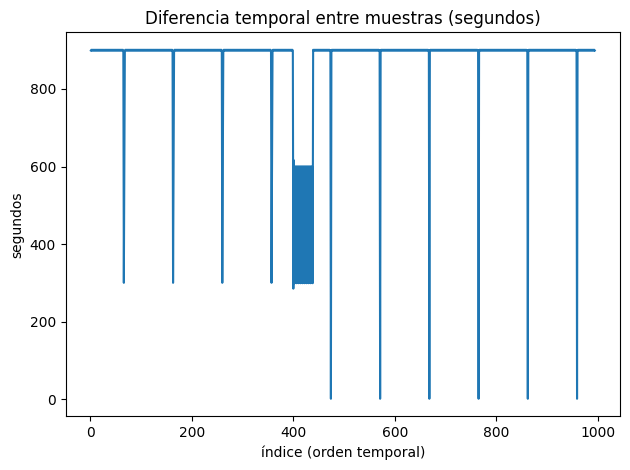

In [19]:
plt.figure()
plt.plot(delta.values)
plt.title("Diferencia temporal entre muestras (segundos)")
plt.ylabel("segundos"); plt.xlabel("índice (orden temporal)")
plt.tight_layout(); plt.show()




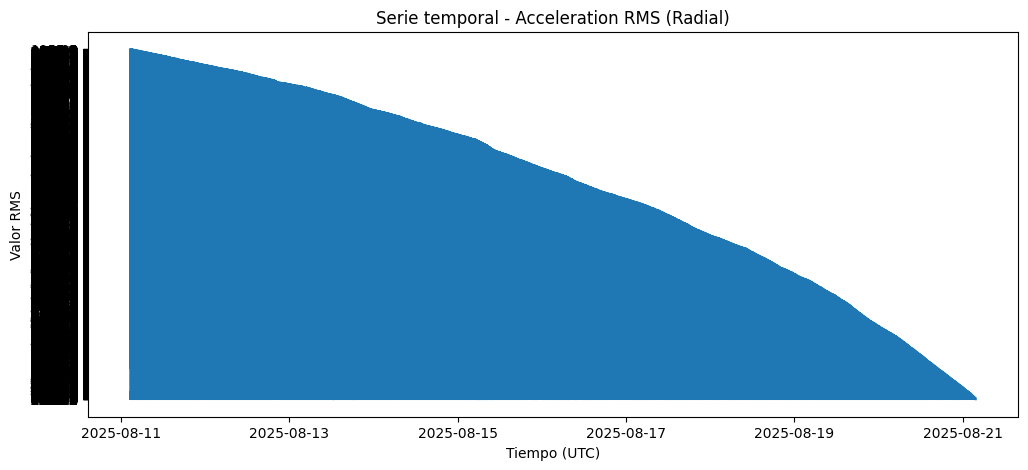

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df['ts_utc'], df['valor'])
plt.title("Serie temporal - Acceleration RMS (Radial)")
plt.xlabel("Tiempo (UTC)")
plt.ylabel("Valor RMS")
plt.show()


## 7) Faltantes y estadísticas

In [21]:

missing_ratio = df_wide.isna().mean().sort_values(ascending=False).rename("missing_ratio")
missing_ratio.head(15)


variable
Output Power                     0.012060
Bearing Condition                0.011055
Acceleration RMS (Radial)        0.010050
Acceleration RMS (Tangential)    0.010050
Looseness (BETA)                 0.010050
Acceleration RMS (Axial)         0.010050
Misalignment (BETA)              0.010050
Motor Supply Frequency           0.010050
Overall Vibration                0.010050
Peak to Peak                     0.010050
Peak to Peak (Radial)            0.010050
Peak to Peak (Axial)             0.010050
Peak to Peak (Tangential)        0.010050
Skin Temperature                 0.010050
Vibration (Radial)               0.010050
Name: missing_ratio, dtype: float64

In [22]:

stats = df.groupby("variable")["valor"].describe().sort_index()
stats.head(10)


,count,unique,top,freq
variable,,,,
Acceleration RMS (Axial),985,312,0.8325,14
Acceleration RMS (Radial),985,466,0.1948,12
Acceleration RMS (Tangential),985,458,0.6084,11
Bearing Condition,984,4,2.0,859
Looseness (BETA),985,1,0.0,985
Misalignment (BETA),985,1,0.0,985
Motor Supply Frequency,985,14,36.25,390
Nr. Of Starts Between Measurements,995,3,0.0,986
Output Power,983,782,99.98,6


## 8) Guardar CSVs

In [23]:
#coverage.to_csv(OUTDIR / "coverage_daily.csv", header=True)
#missing_ratio.to_csv(OUTDIR / "missing_by_variable.csv", header=True)
#stats.to_csv(OUTDIR / "stats_by_variable.csv")
#df.to_csv(OUTDIR / "raw_long.csv", index=False)
#df_wide.to_csv(OUTDIR / "wide_pivot.csv")
#print("✓ Guardados en:", OUTDIR.resolve())
